In [1]:
import os
import csv
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure

## Helper functions to load and process original csv files

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/afeka/y2/sem1/dl/code/LSTM-VAE/VAE-LSTM-for-anomaly-detection/datasets
!ls

Mounted at /content/drive
/content/drive/My Drive/afeka/y2/sem1/dl/code/LSTM-VAE/VAE-LSTM-for-anomaly-detection/datasets
NAB-dataset-preprocessing.ipynb  NAB-known-anomaly  UAV-Attack-Dataset


In [108]:
# this function load one .cvs (a sequence)
def load_data(dataset, csv_folder='./NAB-known-anomaly/csv-files/'):
    print(os.getcwd())
    idx_split = []
    if dataset == 'ambient_temp':
        data_file = os.path.join(csv_folder, 'ambient_temperature_system_failure.csv')
        anomalies = ['2013-12-22 20:00:00', '2014-04-13 09:00:00']
        idx_split = [0, 3000]
        t_unit = 'hour'
    elif dataset == 'cpu_utilization':
        data_file = os.path.join(csv_folder, 'cpu_utilization_asg_misconfiguration.csv')
        anomalies = ['2014-07-12 02:04:00', '2014-07-14 21:44:00']
        idx_split = [0, 3000]
        t_unit = '5 min'
    elif dataset == 'ec2_request':
        data_file = os.path.join(csv_folder, 'ec2_request_latency_system_failure.csv')
        anomalies = ['2014-03-14 09:06:00', '2014-03-18 22:41:00', '2014-03-21 03:01:00']
        idx_split = [0, 3000]
        t_unit = '5 min'
    elif dataset == 'machine_temp':
        data_file = os.path.join(csv_folder, 'machine_temperature_system_failure.csv')
        anomalies = ['2013-12-11 06:00:00', '2013-12-16 17:25:00', '2014-01-28 13:55:00', '2014-02-08 14:30:00']
        idx_split = [0, 3000]
        t_unit = '5 min'
    elif dataset == 'rogue_agent_key_hold':
        data_file = os.path.join(csv_folder, 'rogue_agent_key_hold.csv')
        anomalies = ['2014-07-15 08:30:00', '2014-07-17 09:50:00']
        idx_split = [0, 3000]
        t_unit = '5 min'
    elif dataset == 'rogue_agent_key_updown':
        data_file = os.path.join(csv_folder, 'rogue_agent_key_updown.csv')
        anomalies = ['2014-07-15 04:00:00', '2014-07-17 08:50:00']
        idx_split = [0, 3000]
        t_unit = '5 min'
    elif dataset == 'nyc_taxi':
        data_file = os.path.join(csv_folder, 'nyc_taxi.csv')
        anomalies = ['2014-11-01 19:00:00', '2014-11-27 15:30:00', '2014-12-25 15:00:00', '2015-01-01 01:00:00', 
                     '2015-01-27 00:00:00']
        idx_split = [0, 3000]
        t_unit = '30 min'
    elif dataset == 'PX4-VTOL-SITL':
        csv_folder = './UAV-Attack-Dataset/PX4-VTOL-SITL/GPS-Spoofing/'
        data_file = os.path.join(csv_folder, '2020-08-02-15-31-27-vehicle1-cut.csv')
        anomalies = ['2015-01-27 00:00:00']
        idx_split = [0, 300]
        t_unit = '1 sec'
    elif dataset == 'PX4-QUAD-HITL':
        csv_folder = './UAV-Attack-Dataset/PX4-QUAD-HITL/GPS-Spoofing/'
        data_file = os.path.join(csv_folder, 'vehicle1-2-channels-trim.csv')
        anomalies = ['2020-08-02 19:16:58']
        idx_split = [0, 900]
        t_unit = '1 sec'
    elif dataset == 'PX4-QUAD-SITL':
        csv_folder = './UAV-Attack-Dataset/PX4-QUAD-SITL/GPS-Spoofing/'
        data_file = os.path.join(csv_folder, '2020-08-02-10-13-05-vehicle1-cut.csv')
        anomalies = ['2015-01-27 00:00:00']
        idx_split = [0, 3000]
        t_unit = '1 sec'
    elif dataset == 'PX4-TAIL-SITL':
        csv_folder = './UAV-Attack-Dataset/PX4-TAIL-SITL/GPS-Spoofing/'
        data_file = os.path.join(csv_folder, '2020-08-02-14-58-35-vehicle1-cut.csv')
        anomalies = ['2015-01-27 00:00:00']
        idx_split = [0, 3000]
        t_unit = '1 sec'
    elif dataset == 'PX4-PLANE-SITL':
        csv_folder = './UAV-Attack-Dataset/PX4-PLANE-SITL/GPS-Spoofing/'
        data_file = os.path.join(csv_folder, '2020-08-02-19-56-41-vehicle1-cut.csv')
        anomalies = ['2015-01-27 00:00:00']
        idx_split = [0, 3000]
        t_unit = '1 sec'
    elif dataset == 'PX4-H480-SITL':
        csv_folder = './UAV-Attack-Dataset/PX4-H480-SITL/GPS-Spoofing/'
        data_file = os.path.join(csv_folder, '2020-08-02-14-20-26-vehicle1-cut.csv')
        anomalies = ['2015-01-27 00:00:00']
        idx_split= [0, 3000]
        t_unit = '1 sec'
    
    t = []
    readings = []
    idx_anomaly = []
    i = 0
    with open(data_file) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        print("\n--> Anomalies occur at:")
        for row in readCSV:
            if i > 0:
                t.append(i)
                if len(row) > 2:
                    #print("row: ", row[1:])
                    readings.append(np.array(row[1:], dtype=np.float, order='C'))
                else:
                    readings.append(float(row[1]))
                
                for j in range(len(anomalies)):
                    if row[0] == anomalies[j]:
                        idx_anomaly.append(i)
                        print("  timestamp #{}: {}".format(j, row[0]))
            i = i + 1
    t = np.asarray(t)
    readings = np.asarray(readings)
    print("\nOriginal csv file contains {} timestamps.".format(t.shape))
    print("Processed time series contain {} readings.".format(readings.shape))
    print("Anomaly indices are {}".format(idx_anomaly))
    
    return t, t_unit, readings, idx_anomaly, idx_split, csv_folder

In [109]:
# This function plots a dataset with the train/test split and known anomalies
# Relies on helper function load_data()

def process_and_save_specified_dataset(dataset, y_scale=5, save_file=False):
    t, t_unit, readings, idx_anomaly, idx_split, save_dir = load_data(dataset)
    
    # print("readings: ", readings.shape)
    # split into training and test sets
    training = readings[idx_split[0]:idx_split[1]]
    t_train = t[idx_split[0]:idx_split[1]]

    readings_normalised = np.zeros(readings.shape, dtype=float)
    # print("shape: !!! ", training.shape)

    # normalise by training mean and std 
    train_m = training.mean(axis=0) #np.mean(training[:channel])
    train_std = training.std(axis=0) #np.std(training[:channel])
    print("\nTraining set mean is {}".format(train_m))
    print("Training set std is {}".format(train_std))
    # print("readings_normalised: ", readings_normalised[:,1])
    channels_num = len(train_m)
    for channel in range(channels_num):
        readings_normalised[:,channel] = (readings[:,channel] - train_m[channel]) / train_std[channel]
    
    training = readings_normalised[idx_split[0]:idx_split[1]]
    if idx_split[0] == 0:
        test = readings_normalised[idx_split[1]:]
        t_test = t[idx_split[1]:] - idx_split[1]
        idx_anomaly_test = np.asarray(idx_anomaly) - idx_split[1]
    else:
        test = [readings_normalised[:idx_split[0]], readings_normalised[idx_split[1]:]]
        t_test = [t[:idx_split[0]], t[idx_split[1]:] - idx_split[1]]
        idx_anomaly_split = np.squeeze(np.argwhere(np.asarray(idx_anomaly)>idx_split[0]))
        idx_anomaly_test = [np.asarray(idx_anomaly[:idx_anomaly_split[0]]), 
                            np.asarray(idx_anomaly[idx_anomaly_split[0]:]) - idx_split[1]]
    print("Anomaly indices in the test set are {}".format(idx_anomaly_test))
    
    if save_file:
        #save_dir = './datasets/NAB-known-anomaly/'
        np.savez(save_dir+dataset+'.npz', t=t, t_unit=t_unit, readings=readings, idx_anomaly=idx_anomaly,
                    idx_split=idx_split, training=training, test=test, train_m=train_m, train_std=train_std,
                    t_train=t_train, t_test=t_test, idx_anomaly_test=idx_anomaly_test)
        print("\nProcessed time series are saved at {}".format(save_dir+dataset+'.npz'))
    else:
        print("\nProcessed time series are not saved.")
    
    # plot the whole normalised sequence
    fig, axs = plt.subplots(channels_num, 1, figsize=(18, 4), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    # print("readings_normalised: ", readings_normalised[:,channel])
    # axs = axs.ravel()
    # for i in range(4):
    for channel in range(channels_num):
        axs[channel].plot(t, readings_normalised[:,channel])
        if idx_split[0] == 0:
            axs[channel].plot(idx_split[1]*np.ones(20), np.linspace(-y_scale,y_scale,20), 'b--')
        else:
            for i in range(2):
                axs[channel].plot(idx_split[i]*np.ones(20), np.linspace(-y_scale,y_scale,20), 'b--')
        for j in range(len(idx_anomaly)):
            axs[channel].plot(idx_anomaly[j]*np.ones(20), np.linspace(-y_scale,y_scale,20), 'r--')
        #     axs.plot(data[:,1])
        axs[channel].grid(True)
        axs[channel].set_xlim(0, len(t))
        axs[channel].set_ylim(-y_scale, y_scale)
        axs[channel].set_xlabel("timestamp (every {})".format(t_unit))
        axs[channel].set_ylabel("normalised readings")
        axs[channel].set_title("{} dataset\n(normalised by train mean {:.2f} and std {:.2f})".format(dataset, train_m[channel], train_std[channel]))
        axs[channel].legend(('data', 'train test set split', 'anomalies'))
    
    return t, readings_normalised

## Example on ambient temperature series

/content/drive/My Drive/afeka/y2/sem1/dl/code/LSTM-VAE/VAE-LSTM-for-anomaly-detection/datasets

--> Anomalies occur at:
  timestamp #0: 2020-08-02 19:16:58

Original csv file contains (1483,) timestamps.
Processed time series contain (1483, 2) readings.
Anomaly indices are [1150]

Training set mean is [  2.05733333 -28.98522222]
Training set std is [2.28781351 7.1575596 ]
Anomaly indices in the test set are [250]

Processed time series are saved at ./UAV-Attack-Dataset/PX4-QUAD-HITL/GPS-Spoofing/PX4-QUAD-HITL.npz


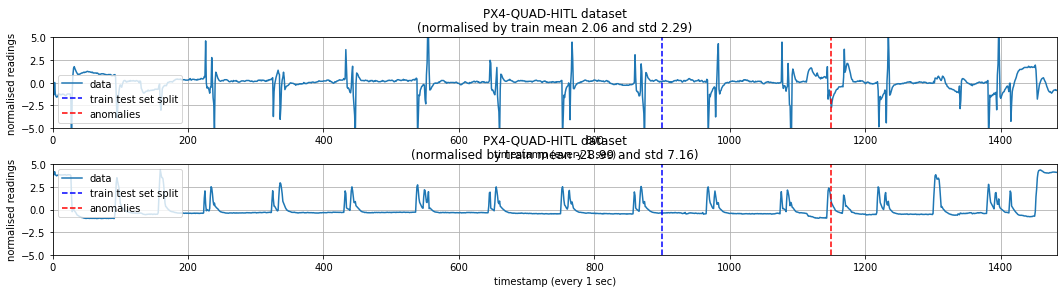

In [110]:
dataset = 'PX4-QUAD-HITL'
#idx_split = [0,3300]

t, readings_normalised = process_and_save_specified_dataset(dataset, save_file=True)#, idx_split)